<a href="https://colab.research.google.com/github/karou1182001/NLPAssigments/blob/main/Assigment2/NLPAssigment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preguntas:
-El dataset que debemos usar es el mismo que el usa en los ejemplos del Github  Rta: Si
- Que cosas debemos comparar al comparar char level y word level y por que me dan los resultados asi: Histogram de todos las freq
- No se que se supone que debo cambiar en el modelo

Nuevas preguntas:

-Resultados de la comparacion estanan bien. En especial el seq len SI

2. Nuevas preguntas

- Cuando dice que el mejor modelo sea identificado, se refiere a la mejor configuracion?
- preguntar la diferencia entre Final Evaluation on Test Set y evaluar en el de validacion. O mas bien. donde uso el final evakuation teste
- cuando dice: Best model should be compared with random model shown above.. Se refiere a comparar los resxultados de la mejor configuracion con los otros

# 1. Initial Setup


## Set Random Seeds:
Ensure reproducibility by setting seeds for all random number generators (e.g., Python’s random, NumPy, TensorFlow/PyTorch).

In [1]:
import random
import numpy as np
import torch
import tensorflow as tf

# Set random seed to 42
SEED = 1234

# Python random
random.seed(SEED)

# NumPy
np.random.seed(SEED)


torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


tf.random.set_seed(SEED)

print("Confirmation")


Confirmation


## Prepare the Environment:

Create a new or update an existing Jupyter Notebook.
Ensure that all necessary libraries (e.g., NumPy, pandas, TensorFlow/PyTorch, matplotlib, etc.) are installed.

In [ ]:
!pip install numpy pandas matplotlib seaborn torch torchvision tensorflow


# 2. Preprocessing

## Load Dataset:
Load your dataset into the notebook.



In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# -------------------------------
# Load and Prepare the IMDB Dataset
# -------------------------------
print("Loading IMDB dataset...")
# Load the IMDB reviews dataset with the 'as_supervised' flag so that we get (text, label) pairs.
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
                                           split=['train', 'test'],
                                           as_supervised=True,
                                           with_info=True)

# Convert training dataset to lists.
train_texts = []
train_labels = []
for text, label in tfds.as_numpy(ds_train):
    # Decode byte strings to utf-8 strings.
    train_texts.append(text.decode('utf-8'))
    train_labels.append(label)
train_labels = np.array(train_labels)

# Create a validation set from the training data (20% for validation).
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# Convert test dataset to lists.
test_texts = []
test_labels = []
for text, label in tfds.as_numpy(ds_test):
    test_texts.append(text.decode('utf-8'))
    test_labels.append(label)
test_labels = np.array(test_labels)

print(f"Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}, Test samples: {len(test_texts)}")


Loading IMDB dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HAFCF_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HAFCF_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HAFCF_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Train samples: 20000, Validation samples: 5000, Test samples: 25000


## Tokenization:





### Character-Level Tokenization:
Tokenize the text data at the character level.
Save and log the processed data.


In [3]:
# -------------------------------
# Character-Level Tokenizer and Preprocessing Functions
# -------------------------------
def char_level_tokenizer(texts, num_words=None):
    """
    Create and fit a character-level tokenizer.

    Args:
        texts (list of str): List of texts.
        num_words (int or None): Maximum number of tokens to keep.

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, char_level=True, lower=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def texts_to_bow(tokenizer, texts):
    """
    Convert texts to a bag-of-characters representation.

    Args:
        tokenizer: A fitted character-level Tokenizer.
        texts (list of str): List of texts.

    Returns:
        Numpy array representing the binary bag-of-characters for each text.
    """
    # texts_to_matrix with mode 'binary' produces a fixed-length binary vector per text.
    matrix = tokenizer.texts_to_matrix(texts, mode='binary')
    return matrix

def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    Convierte las palabras categorigas en un formato numerico
    """
    return np.eye(num_classes)[labels]

# -------------------------------
# Preprocessing: Tokenization and Vectorization
# -------------------------------

# Build the character-level tokenizer on the training texts.
tokenizer = char_level_tokenizer(train_texts)
print("Tokenizer vocabulary size:", len(tokenizer.word_index) + 1)

# Convert texts to bag-of-characters representation.
X_train = texts_to_bow(tokenizer, train_texts)
X_val   = texts_to_bow(tokenizer, val_texts)
X_test  = texts_to_bow(tokenizer, test_texts)

# Convert labels to one-hot encoding.
y_train = one_hot_encode(train_labels)
y_val   = one_hot_encode(val_labels)
y_test  = one_hot_encode(test_labels)

Tokenizer vocabulary size: 134


### Word-Level Tokenization:
Modify the tokenization process to tokenize the text by words.
Save and log the processed data.

In [4]:
# -------------------------------
# Word-Level Tokenizer and Preprocessing Functions
# -------------------------------
def word_tokenizer(texts, num_words=None):
    """
    Create and fit a word-level tokenizer.

    Args:
        texts (list of str): List of texts.
        num_words (int or None): Maximum number of tokens to keep.

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    #We put char_level= False to be word level
    wordTokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, lower=True)
    wordTokenizer.fit_on_texts(texts)
    return wordTokenizer

def texts_to_bow(tokenizer, texts):
    """
    Convert texts to a bag-of-characters representation.

    Args:
        tokenizer: A fitted character-level Tokenizer.
        texts (list of str): List of texts.

    Returns:
        Numpy array representing the binary bag-of-characters for each text.
    """
    # texts_to_matrix with mode 'binary' produces a fixed-length binary vector per text.
    matrix = tokenizer.texts_to_matrix(texts, mode='binary')
    return matrix

def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    Convierte las palabras categorigas en un formato numerico
    """
    return np.eye(num_classes)[labels]

# -------------------------------
# Preprocessing: Tokenization and Vectorization
# -------------------------------
# Build the character-level tokenizer on the training texts.
wordTokenizer = word_tokenizer(train_texts)
print("Word Tokenizer vocabulary size:", len(wordTokenizer.word_index) + 1)

# Convert texts to bag-of-characters representation.
X_train_word = texts_to_bow(wordTokenizer, train_texts)
X_val_word   = texts_to_bow(wordTokenizer, val_texts)
X_test_word  = texts_to_bow(wordTokenizer, test_texts)

# Convert labels to one-hot encoding.
y_train_word = one_hot_encode(train_labels)
y_val_word   = one_hot_encode(val_labels)
y_test_word  = one_hot_encode(test_labels)



Word Tokenizer vocabulary size: 80169


## Comparison:

Create a section in your notebook to compare the two tokenization approaches.
Visualize or tabulate differences in vocabulary size, sequence lengths, and other relevant metrics.

Character level vocabulary size: 134
Word level vocabulary size: 80169
char level sequence lengths: [2901, 1168, 2421, 1294, 985, 1514, 741, 546, 434, 1401, 655, 809, 739, 732, 1510, 650, 704, 656, 2258, 791, 2116, 906, 2833, 1493, 732, 781, 1223, 1471, 663, 1349, 1469, 839, 2091, 664, 3124, 476, 646, 997, 662, 1766, 678, 828, 1552, 630, 215, 1904, 386, 1102, 632, 1361, 791, 207, 1499, 1030, 1516, 2122, 1117, 2427, 541, 499, 1944, 984, 758, 439, 2484, 285, 403, 2156, 692, 261, 1508, 709, 1198, 1232, 912, 832, 1697, 1382, 1014, 1412, 1007, 5209, 1129, 1947, 303, 1211, 2456, 1553, 1792, 2809, 826, 775, 2015, 2671, 4081, 3182, 219, 1191, 782, 768, 802, 444, 1301, 446, 532, 4722, 4952, 653, 982, 654, 912, 645, 822, 1227, 2110, 997, 487, 1299, 5030, 1484, 1060, 651, 903, 1266, 723, 603, 650, 1077, 2549, 1199, 665, 4212, 1799, 1145, 316, 681, 1109, 1173, 1065, 491, 637, 1105, 839, 610, 938, 2543, 817, 3584, 685, 2735, 866, 865, 790, 1660, 1803, 2300, 1138, 1105, 3620, 508, 940, 425, 4427, 59

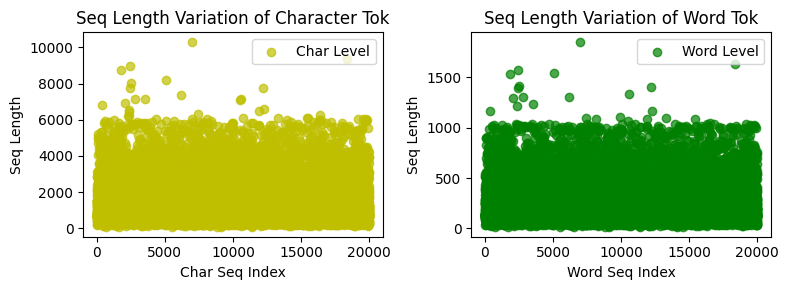

In [6]:
import matplotlib.pyplot as plt
# -------------------------------
# Comparison Between Tokenization Approaches
# -------------------------------
charSize = len(tokenizer.word_index) + 1
wordSize = len(wordTokenizer.word_index) + 1

#Convert to sew of index
charSeq = tokenizer.texts_to_sequences(train_texts)
wordSeq = wordTokenizer.texts_to_sequences(train_texts)

charseqLen =  [len(seq) for seq in charSeq]
wordseqLen = [len(seq) for seq in wordSeq]

print("Character level vocabulary size:", charSize)
print("Word level vocabulary size:", wordSize)
print("char level sequence lengths:", charseqLen)
print("word level sequence lengths:", wordseqLen)

# index for each seq
charLen= len(charseqLen)
wordLen = len(wordseqLen)


plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.scatter(np.arange(charLen), charseqLen, color='y', alpha=0.7)
plt.xlabel('Char Seq Index')
plt.ylabel('Seq Length')
plt.title('Seq Length Variation of Character Tok')
plt.legend(['Char Level'])

plt.subplot(1, 2, 2)
plt.scatter(np.arange(wordLen), wordseqLen, color='g', alpha=0.7)
plt.xlabel('Word Seq Index')
plt.ylabel('Seq Length')
plt.title('Seq Length Variation of Word Tok')
plt.legend(['Word Level'])


plt.tight_layout()
plt.show()


Analizing, the results makes sense since a the vocabulary of the word should be bigger than the vocabulary of char. And also, when can see in the graph that the number of characters of each text is larger than the number of words, as each word is broken into individual characters. Also, it is interesenting to see that both graphs has similar structure or distribution.

# 3. Model Architecture


## Define the Model:
Develop a model (or models) that can handle both tokenization types. Include the following adjustable hyper-parameters:


*   Learning rate
*   Number of hidden layers
*   Hidden sizes (neurons per layer)
*   Batch sizes
*   Optimizers (e.g., Adam, SGD, RMSProp)
*   Activation functions (e.g., ReLU, Tanh, LeakyReLU)

In [14]:
# -------------------------------
# Model Setup
# -------------------------------
class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_hidden3: int, size of the 3rd hidden layer (not used in compute_output here)
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None.
        """
        self.size_input = size_input
        self.size_hidden1 = size_hidden1
        self.size_hidden2 = size_hidden2
        self.size_hidden3 = size_hidden3  # (Currently not used in the forward pass)
        self.size_output = size_output
        self.device = device

        # Initialize weights and biases for first hidden layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))

        # Initialize weights and biases for second hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

        # Initialize weights and biases for output layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output], stddev=0.1))
        self.b3 = tf.Variable(tf.zeros([1, self.size_output]))

        # List of variables to update during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]

    def forward(self, X):
        """
        Forward pass.
        X: Tensor, inputs.
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device == 'gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)
        return self.y

    def loss(self, y_pred, y_true):
        """
        Computes the loss between predicted and true outputs.
        y_pred: Tensor of shape (batch_size, size_output)
        y_true: Tensor of shape (batch_size, size_output)
        """
        y_true_tf = tf.cast(y_true, dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        loss_x = cce(y_true_tf, y_pred_tf)
        return loss_x

    def backward(self, X_train, y_train):
        """
        Backward pass: compute gradients of the loss with respect to the variables.
        """
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
        grads = tape.gradient(current_loss, self.variables)
        return grads

    def compute_output(self, X):
        """
        Custom method to compute the output tensor during the forward pass.
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)
        # First hidden layer
        h1 = tf.matmul(X_tf, self.W1) + self.b1
        z1 = tf.nn.relu(h1)
        # Second hidden layer
        h2 = tf.matmul(z1, self.W2) + self.b2
        z2 = tf.nn.relu(h2)
        # Output layer (logits)
        output = tf.matmul(z2, self.W3) + self.b3
        return output


# The input size is determined by the dimension of the bag-of-characters vector.
size_input = X_train.shape[1]
# Set hidden layer sizes as desired.
size_hidden1 = 128
size_hidden2 = 64
size_hidden3 = 32  # Placeholder (not used in the forward pass)
size_output  = 2

# Instantiate the MLP model.
model = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None)

# Define the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

This model works for both tokenizers since we are passing as parameters a vector of indices. The only thing that we need to change to use with the word level tokenizer is the sizeinput parameter, so we use X_train word.

# 4. Hyper-Parameter Optimization



## Experiment Setup:

For each hyper-parameter configuration, perform at least 3 different tests to ensure robustness.

## Grid/Random Search:
Set up a search over the following hyper-parameter ranges (example values provided):

* Learning Rate: [0.001, 0.0005, 0.0001]
* Hidden Layers: [1, 2, 3]
* Hidden Sizes: [128, 256, 512]
* Batch Sizes: [32, 64, 128]
* Optimizers: [Adam, SGD, RMSProp]
* Activation Functions: [ReLU, Tanh, LeakyReLU]


## Logging:
Record the results (accuracy, loss, etc.) for each configuration in tables or charts.

In [12]:
# -------------------------------
# Training Parameters and Loop
# -------------------------------
import itertools
import random

#Hyperparameters
learning_rates = [0.001, 0.0005, 0.0001]
hidden_layers = [1, 2, 3]
hidden_sizes = [128, 256, 512]
batch_sizes = [32, 64, 128]
optimizers = ["Adam", "SGD", "RMSprop"]
activations = ["relu", "tanh", "leaky_relu"]

# try all configurations
hyperparam_grid = list(itertools.product(learning_rates, hidden_layers, hidden_sizes, batch_sizes, optimizers, activations))

perct = 0.01  # 30% of comb
numSamples = int(len(hyperparam_grid) * perct)
hyperparam_grid = random.sample(hyperparam_grid, numSamples)

print("total samples", numSamples)
#for config in hyperparam_grid:
#    print(config)
#729 comb

total samples 7


Instead of trying with all configurations of parameters, we are going to test with a small portion since all combinations will be 729 and it will take long time.

# 5. Model Training and Evaluation
## Training with Each Configuration:
Run experiments for both tokenization approaches with each set of hyper-parameters:

Train the model at least 3 times per configuration (keeping the seed constant at this stage).
Log training and validation performance.
## Identify the Best Model:
Select the best performing configuration based on validation metrics (e.g., accuracy).

In [15]:
results = []

for lr, num_layers, hidden_size, batch_size, optimizer_name, activation in hyperparam_grid:
    print(f"\nTrying hyperparameters: LR={lr}, Layers={num_layers}, Hidden Size={hidden_size}, Batch={batch_size}, Optimizer={optimizer_name}, Activation={activation}")

    # To save results of the trials
    accuracies = []
    val_losses = []

    # -------------------------------
    # 3 test per conf
    # -------------------------------
    for trial in range(3):
        print(f"\nTrial {trial + 1} starting...")

        # model
        model = MLP(size_input, hidden_size, hidden_size, hidden_size, size_output)

        #optimizer
        if optimizer_name == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer_name == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

        # activation function
        activation_fn = tf.nn.relu if activation == "relu" else tf.nn.tanh if activation == "tanh" else tf.nn.leaky_relu

        print("\nStarting training...\n")
        epochs = 10
        num_batches = int(np.ceil(X_train.shape[0] / batch_size))

        for epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            epoch_loss = 0
            for i in range(num_batches):
                start, end = i * batch_size, min((i + 1) * batch_size, X_train.shape[0])
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                predictions = model.forward(X_batch)
                loss_value = model.loss(predictions, y_batch)
                grads = model.backward(X_batch, y_batch)
                optimizer.apply_gradients(zip(grads, model.variables))
                epoch_loss += loss_value.numpy() * (end - start)

            epoch_loss /= X_train.shape[0]

        # Evaluate on validation set
        val_logits = model.forward(X_val)
        val_loss = model.loss(val_logits, y_val).numpy()
        val_preds = np.argmax(val_logits.numpy(), axis=1)
        true_val = np.argmax(y_val, axis=1)
        accuracy = np.mean(val_preds == true_val)
        precision = precision_score(true_val, val_preds)
        recall = recall_score(true_val, val_preds)

        # Save results per trial
        accuracies.append(accuracy)
        val_losses.append(val_loss)

    # avf result of 3 trials
    avg_accuracy = np.mean(accuracies)
    avg_val_loss = np.mean(val_losses)

    # # Save mean results
    results.append((lr, num_layers, hidden_size, batch_size, optimizer_name, activation, avg_accuracy, avg_val_loss))

# Sort by prec
results.sort(key=lambda x: -x[6])

# Print sorted results as a table
table_header = "| LR | Layers | Hidden Size | Batch | Optimizer | Activation | Accuracy | Val Loss |"
table_separator = "|----|--------|-------------|-------|-----------|------------|----------|---------|"
print(table_header)
print(table_separator)
for res in results:
    print(f"| {res[0]} | {res[1]} | {res[2]} | {res[3]} | {res[4]} | {res[5]} | {res[6]:.4f} | {res[7]:.4f} |")

# best conf
best_result = results[0]

print("\nBest config:")
print(f"LR={best_result[0]}, Layers={best_result[1]}, Hidden Size={best_result[2]}, "
      f"Batch={best_result[3]}, Optimizer={best_result[4]}, Activation={best_result[5]} "
      f"-> Accuracy={best_result[6]:.4f}, Val Loss={best_result[7]:.4f}")



Trying hyperparameters: LR=0.0005, Layers=1, Hidden Size=512, Batch=128, Optimizer=RMSprop, Activation=leaky_relu

Trial 1 starting...

Starting training...


Trial 2 starting...

Starting training...


Trial 3 starting...

Starting training...


Trying hyperparameters: LR=0.001, Layers=3, Hidden Size=128, Batch=64, Optimizer=Adam, Activation=relu

Trial 1 starting...

Starting training...


Trial 2 starting...

Starting training...


Trial 3 starting...

Starting training...


Trying hyperparameters: LR=0.001, Layers=1, Hidden Size=512, Batch=64, Optimizer=SGD, Activation=tanh

Trial 1 starting...

Starting training...


Trial 2 starting...

Starting training...


Trial 3 starting...

Starting training...


Trying hyperparameters: LR=0.0005, Layers=3, Hidden Size=256, Batch=64, Optimizer=RMSprop, Activation=leaky_relu

Trial 1 starting...

Starting training...


Trial 2 starting...

Starting training...


Trial 3 starting...

Starting training...


Trying hyperparameters: LR=0.001, L

# 6. Final Experiments
## Robustness Check:
Once the best model is identified:

- Re-run the experiments at least 3 times with different random seeds.
- Record the performance (accuracy) for each run.

## Statistical Reporting:

- Compute the mean accuracy and standard error across these runs.
- Include these statistics in your report.

In [16]:
import numpy as np
from scipy.stats import sem  # Standard Error
import pandas as pd

# best conf found
best_lr, best_layers, best_hidden_size, best_batch, best_optimizer, best_activation, _, _ = best_result

# Robustness Check: RRepeat 3 times with dif seeds
num_trials = 3
robust_accuracies = []
results = []

print("\nRunning robustness check...")

for seed in range(num_trials):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    print(f"\nTrial {seed + 1} with seed {seed} starting...")

    # model
    model = MLP(size_input, best_hidden_size, best_hidden_size, best_hidden_size, size_output)

    # optimizer
    if best_optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
    elif best_optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)

    # activation function
    activation_fn = tf.nn.relu if best_activation == "relu" else tf.nn.tanh if best_activation == "tanh" else tf.nn.leaky_relu

    # Training loop
    epochs = 10
    num_batches = int(np.ceil(X_train.shape[0] / best_batch))

    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(num_batches):
            start, end = i * best_batch, min((i + 1) * best_batch, X_train.shape[0])
            X_batch, y_batch = X_train[start:end], y_train[start:end]

            predictions = model.forward(X_batch)
            loss_value = model.loss(predictions, y_batch)
            grads = model.backward(X_batch, y_batch)
            optimizer.apply_gradients(zip(grads, model.variables))

    ## Evaluate on validation set.
    val_logits = model.forward(X_val)
    val_preds = np.argmax(val_logits.numpy(), axis=1)
    true_val = np.argmax(y_val, axis=1)
    accuracy = np.mean(val_preds == true_val)


    robust_accuracies.append(accuracy)
    results.append({'Trial': seed + 1, 'Seed': seed, 'Accuracy': accuracy})

#Each trial resukts
df_results = pd.DataFrame(results)

print("\nResults for each trial:")
print(df_results)


#stat final results
mean_accuracy = np.mean(robust_accuracies)
std_error = sem(robust_accuracies)  # Error estándar de la media
print("\nResults:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Error: {std_error:.4f}")



Running robustness check...

Trial 1 with seed 0 starting...

Trial 2 with seed 1 starting...

Trial 3 with seed 2 starting...

Results for each trial:
   Trial  Seed  Accuracy
0      1     0    0.6020
1      2     1    0.5792
2      3     2    0.5972

Results:
Mean Accuracy: 0.5928
Standard Error: 0.0069


# Best model vs Random model comparison

In [17]:
# -------------------------------
# Final Evaluation on Test Set
# -------------------------------
print("\nEvaluating on test set...")
test_logits = model.forward(X_test)
test_loss = model.loss(test_logits, y_test).numpy()
test_preds = np.argmax(test_logits.numpy(), axis=1)
true_test = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_preds == true_test)
test_precision = precision_score(true_test, test_preds)
test_recall = recall_score(true_test, test_preds)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | "
      f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")



Evaluating on test set...
Test Loss: 0.6624 | Test Accuracy: 0.6060 | Test Precision: 0.5989 | Test Recall: 0.6418
